In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [75]:
df = pd.read_csv('https://raw.githubusercontent.com/Branden-Kang/Building-a-Stock-Prediction-Model-in-Python/main/data/aapl_stock.csv')

In [76]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/13/2020,$119.26,81688590,$119.44,$119.6717,$117.87
1,11/12/2020,$119.21,103350700,$119.62,$120.53,$118.57
2,11/11/2020,$119.49,112295000,$117.19,$119.63,$116.44
3,11/10/2020,$115.97,138023400,$115.55,$117.59,$114.13
4,11/09/2020,$116.32,154515300,$120.5,$121.99,$116.05


In [77]:
df.tail(7)

,Date,Close/Last,Volume,Open,High,Low
246,11/22/2019,$65.445,65325040,$65.6475,$65.795,$65.21
247,11/21/2019,$65.5025,121395120,$65.9225,$66.0012,$65.295
248,11/20/2019,$65.7975,106439680,$66.385,$66.5208,$65.1
249,11/19/2019,$66.5725,76278400,$66.975,$67,$66.3482
250,11/18/2019,$66.775,86803600,$66.45,$66.8575,$66.0575
251,11/15/2019,$66.44,100374680,$65.92,$66.445,$65.7525
252,11/14/2019,$65.66,89582240,$65.9375,$66.22,$65.525


# Feature Engineering

In [78]:
df.rename(columns={' Close/Last':'Close'},inplace=True)

In [79]:
df.head()

,Date,Close,Volume,Open,High,Low
0,11/13/2020,$119.26,81688590,$119.44,$119.6717,$117.87
1,11/12/2020,$119.21,103350700,$119.62,$120.53,$118.57
2,11/11/2020,$119.49,112295000,$117.19,$119.63,$116.44
3,11/10/2020,$115.97,138023400,$115.55,$117.59,$114.13
4,11/09/2020,$116.32,154515300,$120.5,$121.99,$116.05


In [80]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,11/13/2020,$119.26
1,11/12/2020,$119.21
2,11/11/2020,$119.49
3,11/10/2020,$115.97
4,11/09/2020,$116.32


In [81]:
df.dtypes

Date     object
Close    object
dtype: object

In [82]:
df = df.replace({'\$':''}, regex = True)

In [83]:
df = df.astype({"Close": float})

df["Date"] = pd.to_datetime(df.Date, format="%m/%d/%Y")

df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [84]:
df.index = df['Date']

# Explorary Data Analysis

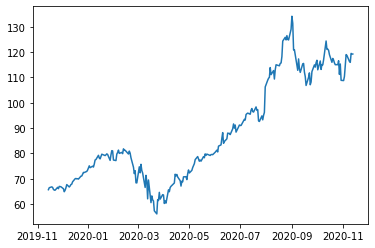

In [85]:
plt.plot(df["Close"],label='Close Price history')

# LSTM Prediction Model

In [86]:
df = df.sort_index(ascending=True,axis=0)

In [87]:
data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [88]:
for i in range(0,len(data)):
    data["Date"][i]=df['Date'][i]
    data["Close"][i]=df["Close"][i]
    
data.head()

,Date,Close
0,2019-11-14 00:00:00,65.66
1,2019-11-15 00:00:00,66.44
2,2019-11-18 00:00:00,66.775
3,2019-11-19 00:00:00,66.5725
4,2019-11-20 00:00:00,65.7975


## Min-Max Scaler

In [89]:
scaler=MinMaxScaler(feature_range=(0,1))

data.index=data.Date
data.drop('Date',axis=1,inplace=True)

final_data = data.values
train_data=final_data[0:200,:]
valid_data=final_data[200:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)

x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

## LSTM Model

In [103]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=60,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=60))
lstm_model.add(Dense(1))

model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

## Train and Test Data

In [104]:
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)

In [105]:
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], 60, 1))

In [106]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

140/140 - 3s - loss: 0.0104


In [107]:
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


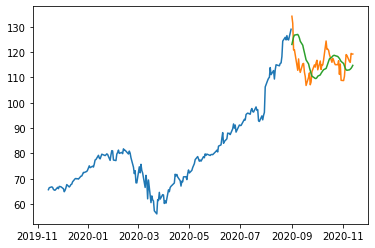

In [108]:
train_data=data[:200]
valid_data=data[200:]
valid_data['Predictions']=predicted_stock_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])